# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.express import colors

# Import Data

In [2]:
url = 'https://raw.githubusercontent.com/eddwebster/football_analytics/master/data/shots/engineered/complete_shots_engineered.csv'
shots_df = pd.read_csv(url, index_col=None)
# Convert isGoal to bool for better visuals
shots_df['isGoal'] = shots_df['isGoal'].astype(bool)

shots_df.describe()

,match_minute,match_second,position_x,position_y,Number_Intervening_Opponents,Number_Intervening_Teammates,position_xM,position_yM,position_xM_r,position_yM_r,...,Interference_on_Shooter_Code,distance_to_goalM,distance_to_centerM,angle,isFoot,isHead,header_distance_to_goalM,High,Low,Medium
count,10165.000000,10165.00000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,...,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000
mean,48.530644,29.32848,14.312324,0.375165,2.416527,0.288342,38.687676,0.376050,-38.687676,-0.376050,...,1.832661,16.903458,7.260149,28.410262,0.817806,0.182194,1.735838,0.164683,0.332022,0.503296
std,26.431160,17.29581,7.749255,8.909779,1.190793,0.600396,7.749255,8.930793,7.749255,8.930793,...,0.684652,7.684998,5.213975,19.056150,0.386023,0.386023,3.932638,0.370912,0.470962,0.500014
min,0.000000,0.00000,0.250000,-33.920000,0.000000,0.000000,-17.820000,-34.000000,-52.750000,-31.243514,...,1.000000,0.353971,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.000000,14.00000,8.480000,-5.990000,2.000000,0.000000,32.550000,-6.004127,-44.520000,-6.745873,...,1.000000,10.890511,2.746462,12.145825,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,49.000000,29.00000,12.470000,0.500000,2.000000,0.000000,40.530000,0.501179,-40.530000,-0.501179,...,2.000000,15.594964,6.254717,26.182500,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,71.000000,44.00000,20.450000,6.730000,3.000000,0.000000,44.520000,6.745873,-32.550000,6.004127,...,2.000000,23.041812,11.246462,41.533688,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,98.000000,59.00000,70.820000,31.170000,11.000000,5.000000,52.750000,31.243514,17.820000,34.000000,...,3.000000,71.787739,34.000000,87.229153,1.000000,1.000000,71.787739,1.000000,1.000000,1.000000


# EDA

There are a lot of different visualization packages for this, but my favorite is plotly because of its interactive features. This will make it easier to identify outliers and individual data points.

In [3]:
# First things first: Overall conversion rate -> 11.23%
print('Overall Conversion Rate: ', sum(shots_df.isGoal)/len(shots_df.isGoal)) # 11.23% shot conversion rate

Overall Conversion Rate:  0.11234628627643876


In [152]:
# Create function to plot histograms given a feature

def feature_hist(df, feature, h, w, x_lab = None, title = None):
    group = df.groupby([feature, 'isGoal']).size().reset_index()
    group['rate'] = df.groupby([feature, 'isGoal']).size().groupby(level = 0).apply(lambda x: x / float(x.sum())).values
    group.columns = [feature, 'isGoal', 'Counts', 'rate']
    group['isGoal'] = pd.Series(np.where(group['isGoal'].values == 1, True, False))
    
    fig = px.bar(group, x = feature, y = 'Counts', color = 'isGoal', 
                 text = group['rate'].apply(lambda x: '{:.0%}'.format(x)),
                 color_discrete_sequence = ['#C41E3A', '#008000'],
                 height = h, width = w,
                 title = title, labels = {feature: x_lab}, template = 'plotly_dark')
    fig.update_traces(textposition = 'outside')
    fig.update_layout(uniformtext_minsize = 7, uniformtext_mode = 'show', showlegend = False)
    
    return fig

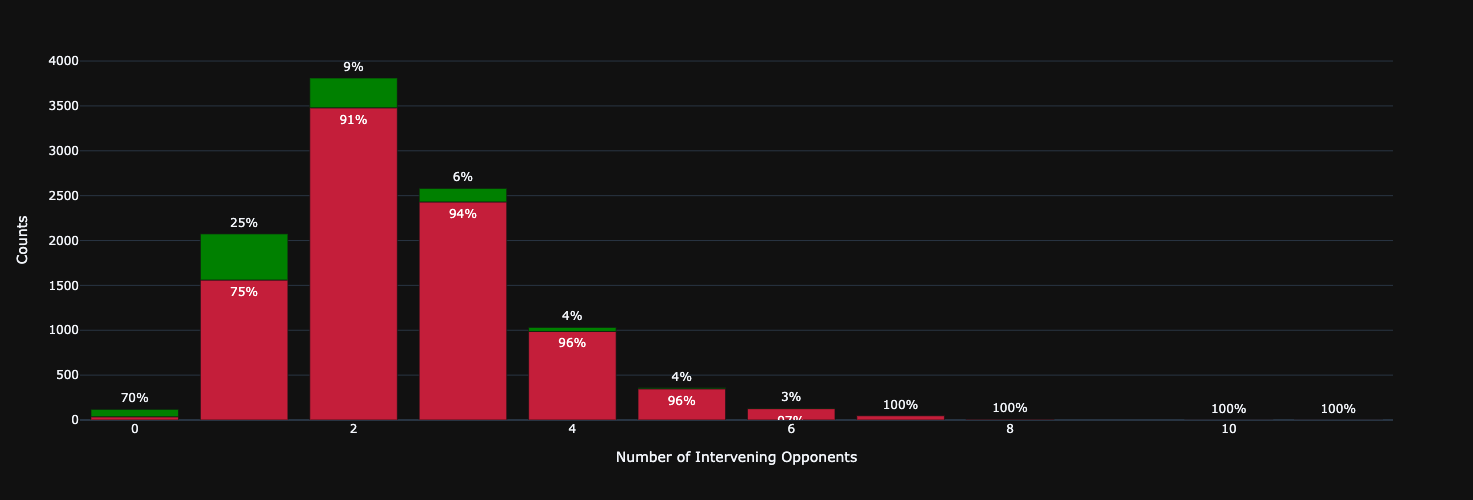

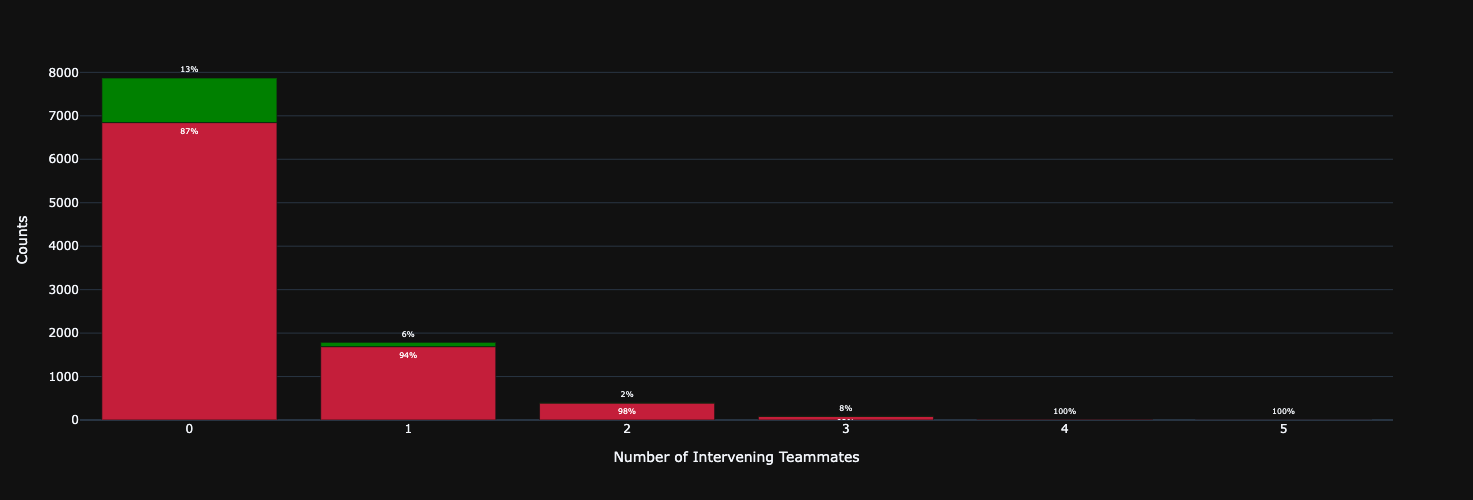

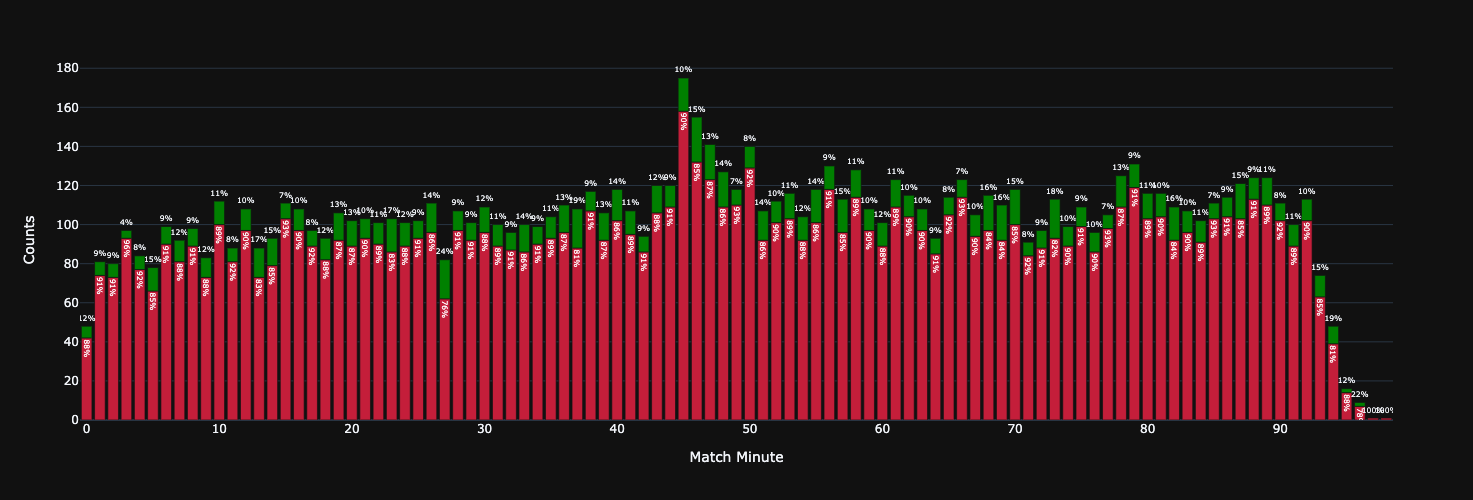

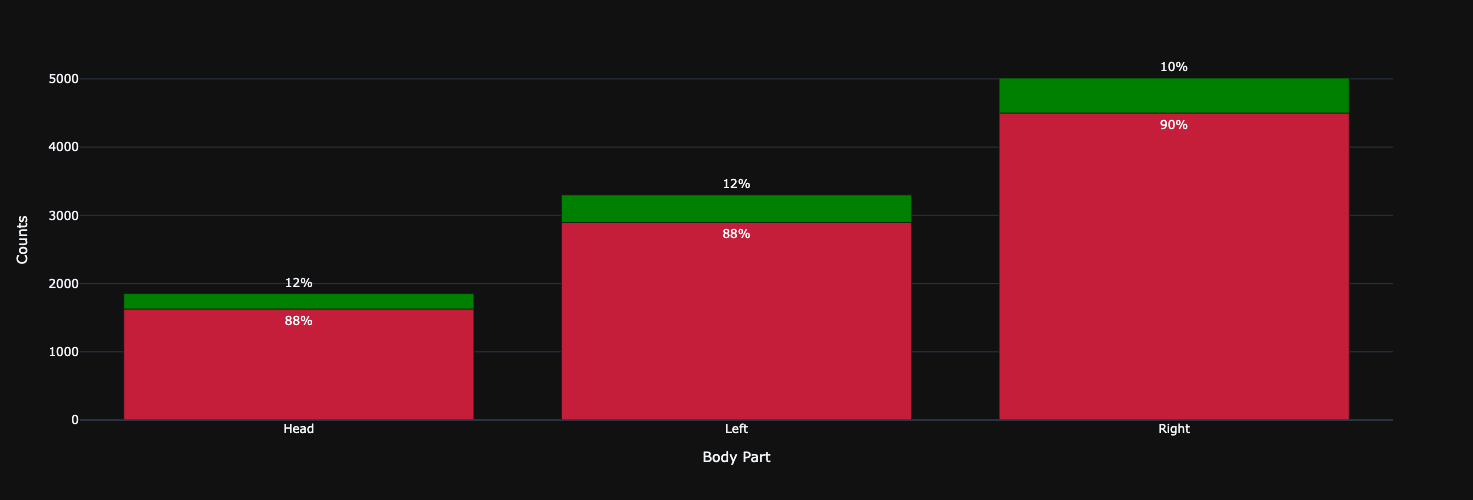

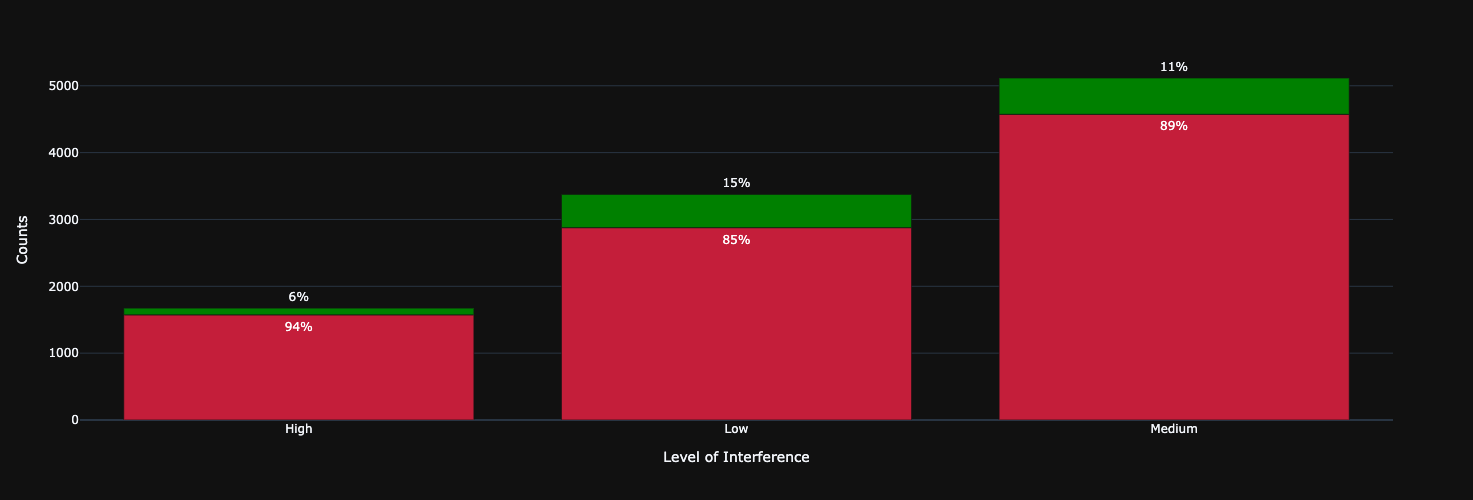

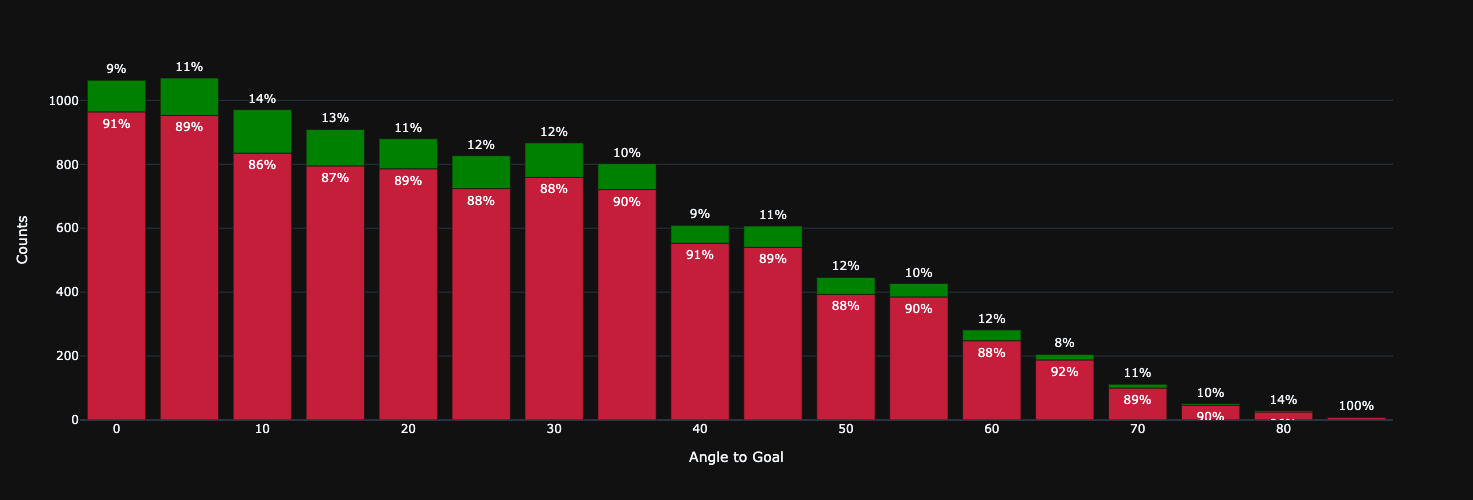

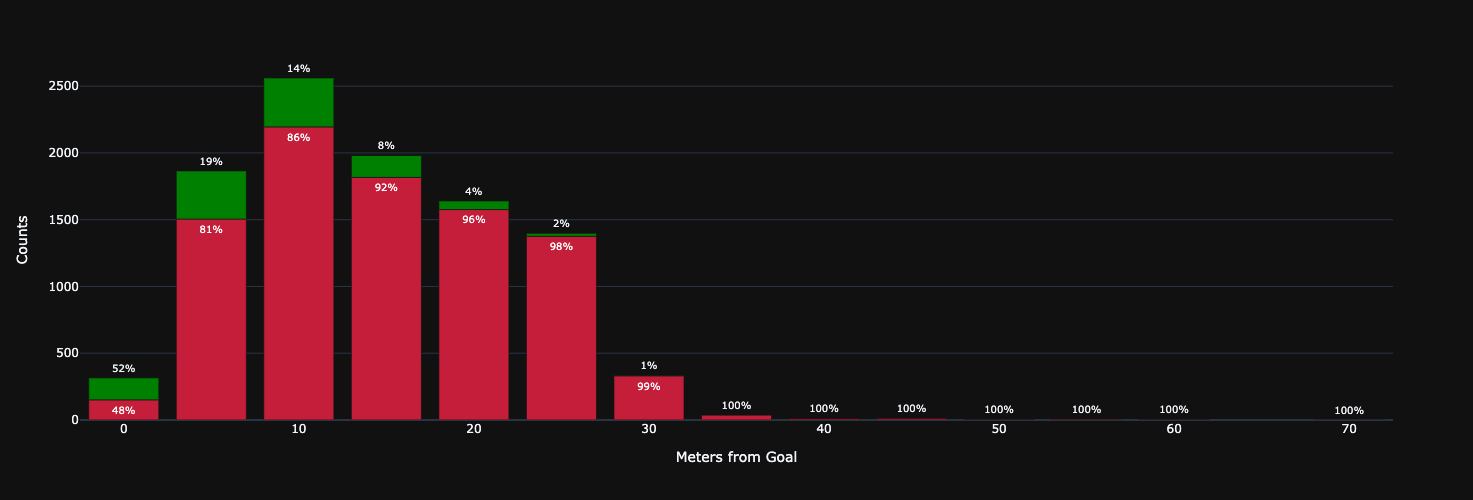

In [153]:
# Histograms for features to compare conversion rates
Num_Opp_Hist = feature_hist(shots_df, 'Number_Intervening_Opponents', 500, 750, 'Number of Intervening Opponents')
Num_Team_Hist = feature_hist(shots_df, 'Number_Intervening_Teammates', 500, 750, 'Number of Intervening Teammates')
Minutes_Hist = feature_hist(shots_df, 'match_minute', 500, 1500, 'Match Minute')
Body_Hist = feature_hist(shots_df, 'BodyPart', 500, 750, 'Body Part')
Int_Hist = feature_hist(shots_df, 'Interference_on_Shooter', 500, 750, 'Level of Interference')

# Create temporary df to segment continuous variables in angle and distance
temp_df = pd.DataFrame()
temp_df['isGoal'] = shots_df['isGoal']
temp_df['angles'] = pd.cut(shots_df['angle'], bins = list(range(0, 96, 5)), include_lowest = True).astype(str).str.split('(').str[1].str.split('.').str[0].replace('-0','0').astype(int)
temp_df['dists'] = pd.cut(shots_df['distance_to_goalM'], bins = list(range(0, 91, 5)), include_lowest = True).astype(str).str.split('(').str[1].str.split('.').str[0].replace('-0','0').astype(int)

# Now we can also fit in histograms for angle and distnace with the same format
Angle_Hist = feature_hist(temp_df, 'angles', 500, 750, 'Angle to Goal')
Dist_Hist = feature_hist(temp_df, 'dists', 500, 750, 'Meters from Goal')

# Create heatmap of conversion rate given coordinates
# heatmap

# Show visuals
Num_Opp_Hist.show()
Num_Team_Hist.show()
Minutes_Hist.show()
Body_Hist.show()
Int_Hist.show()
Angle_Hist.show()
Dist_Hist.show()

In [6]:
max(shots_df['position_y'])

31.17

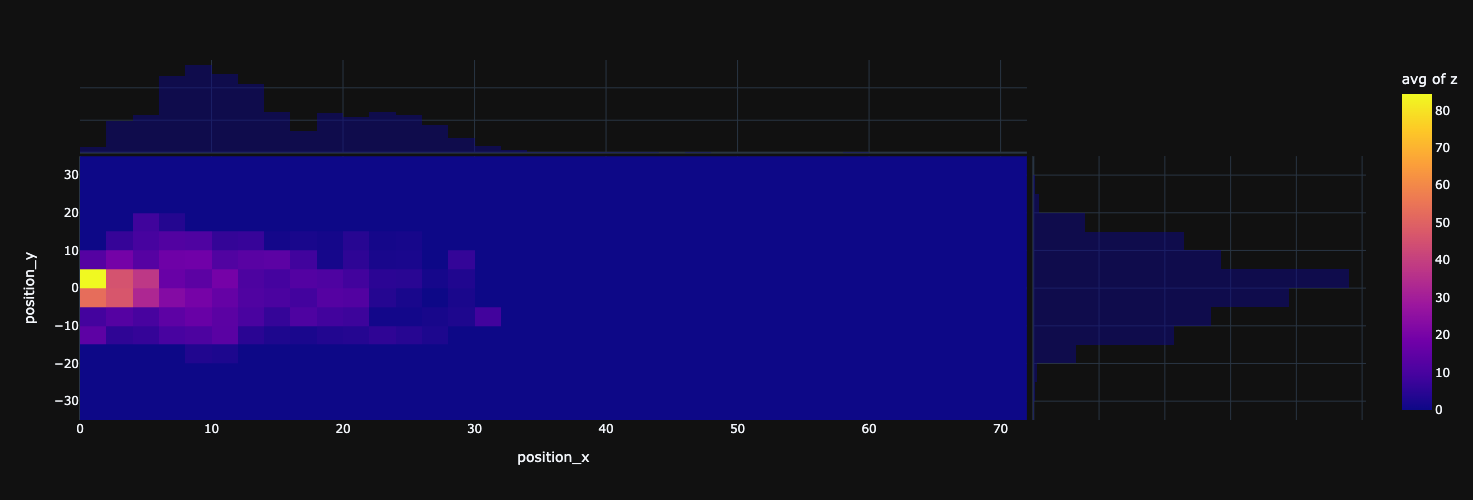

In [154]:
fig = px.density_heatmap(shots_df, x='position_x', y = 'position_y', z = shots_df['isGoal']*100, histfunc = 'avg',
                         marginal_x = 'histogram', marginal_y = 'histogram',
                         nbinsx = 70, nbinsy = 30, height = 500, width = 750, template = 'plotly_dark')
fig.show()

# Feature Selection

From our EDA, the most influential features that we should be aware of are position_x, position_y, angle, and Number_Intervening_Opponents. In order to decide on which features to use during the model training, tuning, and testing process, find the feature importances. Fit a simple random forest model with everything except duplicate features (BodyPart, Interference_on_Shooter), match_second, and outcome since we don't need those. This will give a more precise value on which features we can remove and which are more important.

In [9]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, classification_report, cohen_kappa_score, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split

# Create test and train sets from raw data with 80/20 split
shots_x = shots_df[['match_minute',
                    'position_x',
                    'position_y',
                    'Number_Intervening_Opponents',
                    'Number_Intervening_Teammates',
                    'position_xM',
                    'position_yM',
                    'position_xM_r',
                    'position_yM_r',
                    'position_xM_std',
                    'position_yM_std',
                    'position_xM_std_r',
                    'position_yM_std_r', 
                    'BodyPartCode',
                    'Interference_on_Shooter_Code',
                    'distance_to_goalM',
                    'distance_to_centerM',
                    'angle',
                    'isFoot',
                    'isHead',
                    'header_distance_to_goalM',
                    'High',
                    'Low',
                    'Medium'
                   ]]
shots_y = shots_df['isGoal']
x_train, x_test, y_train, y_test = train_test_split(shots_x, shots_y, test_size = 0.2, shuffle = True, random_state = 0)

In [10]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)

In [11]:
# Print performance metrics
print('\nFeature Importances:')
print(pd.Series(rf.feature_importances_, index = shots_x.columns).sort_values(ascending = False))
print('\nAccuracy:')
print(metrics.accuracy_score(y_test, y_pred))
print('\nROC-AUC:')
print(roc_auc_score(y_test, y_pred))


Feature Importances:
distance_to_goalM               0.105371
match_minute                    0.099539
angle                           0.080740
Number_Intervening_Opponents    0.060489
distance_to_centerM             0.055883
position_xM_r                   0.049911
position_xM_std                 0.049681
position_x                      0.049109
position_xM_std_r               0.047831
position_xM                     0.047534
position_yM_std                 0.047440
position_yM_std_r               0.047269
position_yM_r                   0.047050
position_yM                     0.046918
position_y                      0.046509
header_distance_to_goalM        0.023322
BodyPartCode                    0.021033
Interference_on_Shooter_Code    0.018591
Number_Intervening_Teammates    0.013372
Low                             0.012458
Medium                          0.010442
High                            0.009557
isFoot                          0.005175
isHead                          0.0

It's interesting to see that the most influential feature for converting a shot to a goal is distance_to_goalM. This makes intuitive sense, but putting a numeric value to compare against other features is pretty cool. Further, the specific foot/head dummy variables are less telling than the code counterpart, so we'll use the code features and drop to dummy variables. The sum of the dummy variables for interference level is higher than the coded feature, conversely, so we'll use the dummies. Position coordinates are very important, especially the x coordinate since it relates more closely to the distance from the goal, but we have 10 features that can be reduced to two. Since position_x and position_y are higher up the list in feature_importances_, we'll use these moving forward and drop the others.

Somewhat unexpected is the impact the match_minute shows in this test. It seemed like the rates were randomly distributed, but this shows that there is significant differences minute to minute. This would make sense since the start of a game might yield lower accuracy, or the end of a game with high stakes could sharpen a player's skills to score in the final minutes. Still, continuing on a minute by minute basis wouldn't be prudent, so let's create a new set of variables for 5/10/15/45 minutes chunks in order to give more insight into strategy. Additionally, we'll engineer a total number of intervening players as the sum of teammates and opponents to see if that influences the result more than the two separated.

In [12]:
import warnings
warnings.simplefilter(action = 'ignore')

# Cap match_minute at 89 so that stoppage time is still in the second half, no significant differences in those minutes shown in EDA
shots_x['match_minute'] = np.where(np.array(shots_x['match_minute'].values.tolist()) >= 89, 89, np.array(shots_x['match_minute'].values.tolist()).tolist())

# Feature implementation minutes to 5/10/15/45 minute segments
shots_x['five_minute_chunk'] = shots_x['match_minute']//5
shots_x['ten_minute_chunk'] = shots_x['match_minute']//10
shots_x['fifteen_minute_chunk'] = shots_x['match_minute']//15
shots_x['match_half'] = shots_x['match_minute']//45

# Feature implementation total intervening players
shots_x['Number_Intervening_Total'] = shots_x['Number_Intervening_Teammates'] + shots_x['Number_Intervening_Opponents']

In [13]:
# Redo rf
x_train, x_test, y_train, y_test = train_test_split(shots_x, shots_y, test_size = 0.2, shuffle = True, random_state = 0)
rf = RandomForestClassifier(random_state = 0)
rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)

# Print updated feature importances
print('\nFeature Importances:')
print(pd.Series(rf.feature_importances_, index = shots_x.columns).sort_values(ascending = False))
print('\nAccuracy:')
print(metrics.accuracy_score(y_test, y_pred))
print('\nROC-AUC:')
print(roc_auc_score(y_test, y_pred))


Feature Importances:
distance_to_goalM               0.095619
angle                           0.068963
match_minute                    0.063744
distance_to_centerM             0.051198
position_xM                     0.044890
position_xM_std                 0.044833
position_yM_std                 0.044782
position_yM_std_r               0.043896
position_x                      0.043607
position_y                      0.042929
Number_Intervening_Total        0.042876
position_yM                     0.042789
position_xM_std_r               0.042694
five_minute_chunk               0.042321
position_xM_r                   0.042231
position_yM_r                   0.041195
Number_Intervening_Opponents    0.038631
ten_minute_chunk                0.030083
header_distance_to_goalM        0.022543
fifteen_minute_chunk            0.022524
Interference_on_Shooter_Code    0.018210
BodyPartCode                    0.016557
Low                             0.011439
Number_Intervening_Teammates    0.0

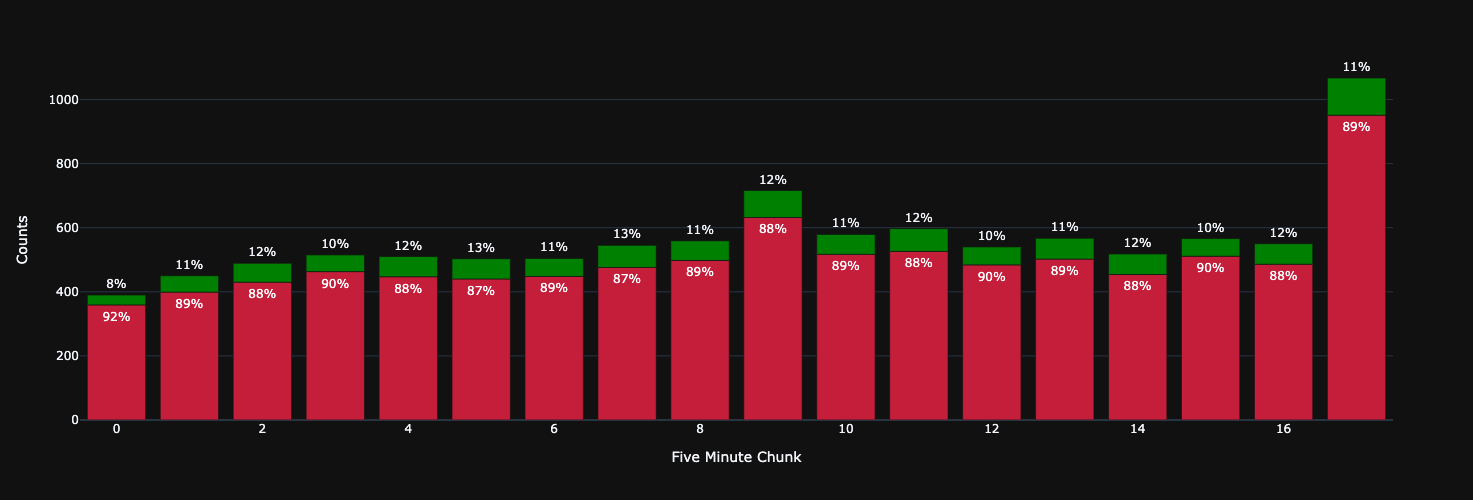

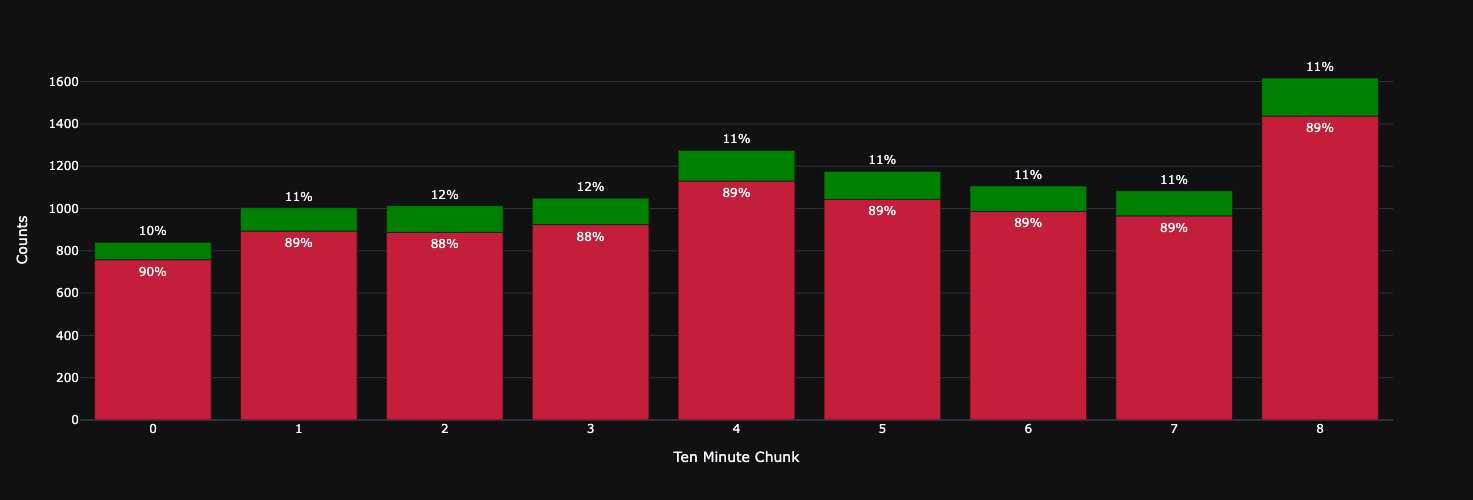

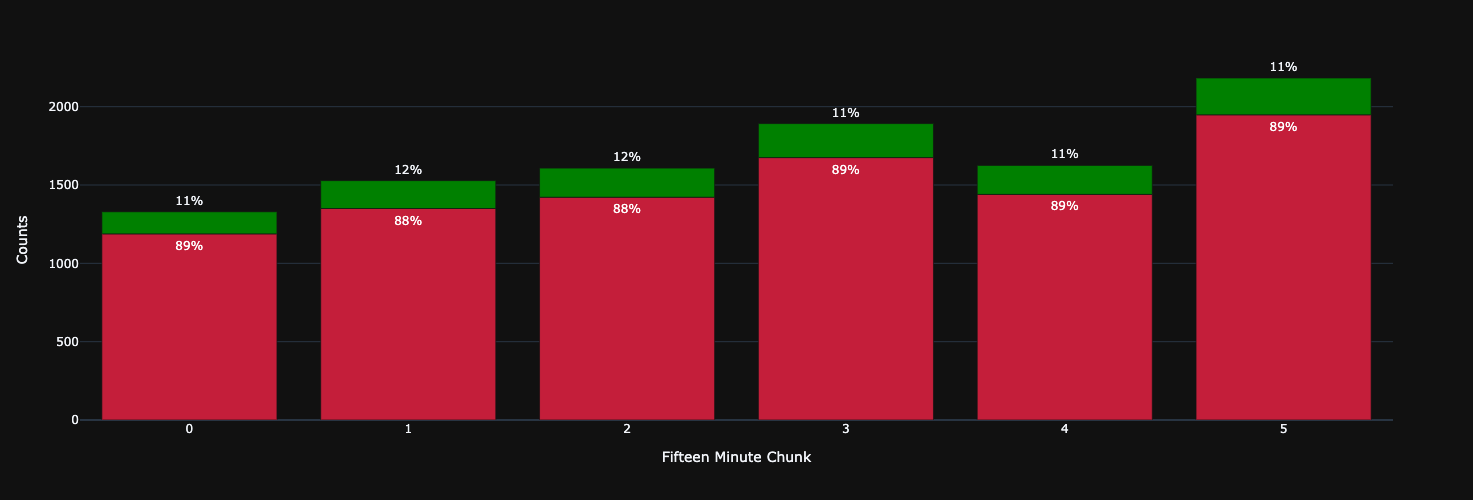

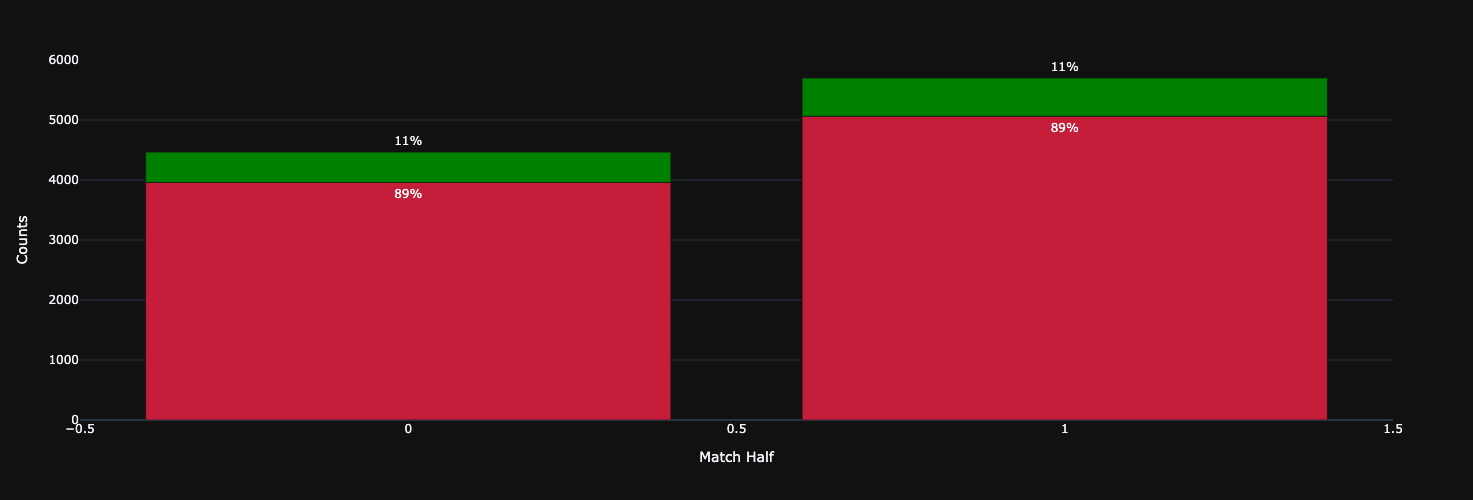

In [155]:
s = shots_x
s['isGoal'] = shots_y

five = feature_hist(s, 'five_minute_chunk', 500, 750, 'Five Minute Chunk')
ten = feature_hist(s, 'ten_minute_chunk', 500, 750, 'Ten Minute Chunk')
fifteen = feature_hist(s, 'fifteen_minute_chunk', 500, 750, 'Fifteen Minute Chunk')
half = feature_hist(s, 'match_half', 500, 750, 'Match Half')

five.show()
ten.show()
fifteen.show()
half.show()

According to this output, the addition of total intervening players does improve our reading of goal conversion. It also shows that as the game time is represented more precisely, the better the predictor becomes. match_half is statistically irrelevant, five_minute_chunk is almost significant, match_minute is one of the best predictors of the whole set. Looking at the visuals for these time divisors, it becomes clear that the reason is likely due to random sampling chance rather than an explanation of shot conversion. Since coaches usually make substitutions during the 60th minute, there should be a noticeable difference in that time window that simply doesn't appear. It's a case of being given a narrower window so the result seem easier to predict because there are more chances for spikes due to randomization to occur.

Using this information, the features that should be used during model training, tuning, and testing process should be distance_to_goalM, header_distance_to_goalM, match_minute, angle, Number_Intervening_Opponents, Number_Intervening_Total, position_x, position_y, Interference_on_Shooter_Code, BodyPartCode, High, Low, Medium.

Before moving on, let's create another visual to see how this feature selection improved the separation of the predictor variable.

# Performance Metrics

The baseline random forest model before hyperparameter tuning is performing at 88.6% accuracy with an ROC_AUC value of 0.594. However, given the fact that about 9% of shots from our data convert to goals, a poor model classifying anything as no goal would yield 91% accuracy. To account for the skew in classification from our dataset, incorporate Precision Recall AUC and Cohen's Kappa metrics to better evaluate during development. As a visibility bonus, add a confusion matrix and classification report.

In [16]:
# Create test and train sets from clean data with 80/20 split
shots_df_clean = shots_x[['distance_to_goalM',
                          'header_distance_to_goalM',
                          'match_minute',
                          'angle',
                          'Number_Intervening_Opponents',
                          'Number_Intervening_Total',
                          'position_x',
                          'position_y',
                          'Interference_on_Shooter_Code',
                          'BodyPartCode',
                          'High',
                          'Low',
                          'Medium'
                         ]]
shots_df_clean['isGoal'] = shots_y
shots_df_clean_x, shots_df_clean_y = shots_df_clean.drop(['isGoal'], axis = 1), shots_df_clean['isGoal']
x_train, x_test, y_train, y_test = train_test_split(shots_df_clean_x, shots_df_clean_y, test_size = 0.2, shuffle = True, random_state = 0)

# Fit model again with clean data
rf = RandomForestClassifier(random_state = 0)
rf.fit(x_train, y_train)

# Make predictions
y_pred = rf.predict(x_test)

In [67]:
# Print performance metrics
def evaluate(y_test, y_pred):
    print('\nAccuracy:')
    print(metrics.accuracy_score(y_test, y_pred))
    print('\nROC-AUC:')
    print(roc_auc_score(y_test, y_pred))
    print('\nPR-AUC:')
    print(average_precision_score(y_test, y_pred))
    print('\nCohen Kappa:')
    print(cohen_kappa_score(y_test, y_pred))
    print('\nConfusion Matrix:')
    print(confusion_matrix(y_test, y_pred))
    print('\nClassification Report:')
    print(classification_report(y_test, y_pred))
    pass

evaluate(y_test, y_pred)


Accuracy:
0.8917855386128873

ROC-AUC:
0.598731776154826

PR-AUC:
0.23296630191995998

Cohen Kappa:
0.27820776823120075

Confusion Matrix:
[[1761   28]
 [ 192   52]]

Classification Report:
              precision    recall  f1-score   support

       False       0.90      0.98      0.94      1789
        True       0.65      0.21      0.32       244

    accuracy                           0.89      2033
   macro avg       0.78      0.60      0.63      2033
weighted avg       0.87      0.89      0.87      2033



# Model Selection and Hyperparameter Tuning

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# Create models
# Logistic Regression
lr = LogisticRegression(random_state = 0).fit(x_train, y_train)

# Naive Bayes
nb = GaussianNB().fit(x_train, y_train)

# Decision Tree
dt = DecisionTreeClassifier(random_state = 0).fit(x_train, y_train)

# ADA Boost
ada = AdaBoostClassifier(learning_rate = 0.1, random_state = 0).fit(x_train, y_train)

# The rest of these models below have some parameters that could be optimized using the GridSearchCV function
# This won't necessarily make a huge impact, but it should get some extra performance points
# KNN
knnparameters = {'n_neighbors': [2, 4, 6, 8, 10, 12]}
knn = GridSearchCV(KNeighborsClassifier(), knnparameters, verbose = 1, scoring = 'average_precision').fit(x_train, y_train)

# RBF SVM
svmparameters = {'gamma': [.01, .2],
                 'C': [0.1, 3.0, 10.0]}
svm = GridSearchCV(SVC(random_state = 0), svmparameters, verbose = 1, scoring = 'average_precision').fit(x_train, y_train)

# Gradient Boost
gbparameters = {'loss': ['log_loss', 'deviance', 'exponential'],
                'n_estimators': [30, 40, 50, 60, 70]}
gb = GridSearchCV(GradientBoostingClassifier(learning_rate = 0.1, random_state = 0), gbparameters, verbose = 1, scoring = 'average_precision').fit(x_train, y_train)

# Random Forest
rfparameters = {'n_estimators': [30, 40, 50, 60, 70],
                'min_samples_split': [50, 100, 150],
               'class_weight': [{0: 1, 1: 5}, {0: 1, 1: 3}, 'balanced']}
rf = GridSearchCV(RandomForestClassifier(random_state = 0), rfparameters, verbose = 1, scoring = 'average_precision').fit(x_train, y_train)

# Neural Net
nnparameters = {'activation': ['relu', 'logistic'],
                'alpha': [.0001, .001, .01, .1]}
nn = GridSearchCV(MLPClassifier(random_state = 0), nnparameters, verbose = 1, scoring = 'average_precision').fit(x_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [61]:
print('Performance Metrics for Logistic Regression Model')
evaluate(y_test, lr.predict(x_test))
print('Performance Metrics for Naive Bayes Model')
evaluate(y_test, nb.predict(x_test))
print('Performance Metrics for Decision Trees Model')
evaluate(y_test, dt.predict(x_test))
print('Performance Metrics for ADA Boost Model')
evaluate(y_test, ada.predict(x_test))
print('Performance Metrics for K Nearest Neighbors Model')
evaluate(y_test, knn.predict(x_test))
print('Performance Metrics for SVM Model')
evaluate(y_test, svm.predict(x_test))
print('Performance Metrics for Gradient Boost Model')
evaluate(y_test, gb.predict(x_test))
print('Performance Metrics for Random Forest Model')
evaluate(y_test, rf.predict(x_test))
print('Performance Metrics for Neural Network Model')
evaluate(y_test, nn.predict(x_test))

Performance Metrics for Linear Regression Model

Accuracy:
0.8883423512051156

ROC-AUC:
0.5684602626249667

PR-AUC:
0.1988841345811986

Cohen Kappa:
0.20573226373301057

Confusion Matrix:
[[1770   19]
 [ 208   36]]

Classification Report:
              precision    recall  f1-score   support

       False       0.89      0.99      0.94      1789
        True       0.65      0.15      0.24       244

    accuracy                           0.89      2033
   macro avg       0.77      0.57      0.59      2033
weighted avg       0.87      0.89      0.86      2033

Performance Metrics for Naive Bayes Model

Accuracy:
0.8229217904574521

ROC-AUC:
0.7082581165409744

PR-AUC:
0.24849273783318857

Cohen Kappa:
0.3319288150198264

Confusion Matrix:
[[1537  252]
 [ 108  136]]

Classification Report:
              precision    recall  f1-score   support

       False       0.93      0.86      0.90      1789
        True       0.35      0.56      0.43       244

    accuracy                         

Reviewing the results, the three best classifier models are Neural Network, Random Forest, and Naive Bayes. Three very different methods which likely yield different predictions. To combine the best of the models, an ensemble model can be built. Ensemble models generate predictions from multiple models and each gets a vote in the final prediction. Voting can be hard or soft meaning a “hard” binomial prediction is generated from each model and the majority gets the ensemble prediction output or a “soft” probability prediction is added from each model and the highest value gets the ensemble prediction output. We'll use both to compare performance results, but in the final xG prediction column will be generated using the soft voting method since hard voting doesn’t allow for a probabilistic prediction output.

In [151]:
from sklearn.ensemble import VotingClassifier

# Build Ensemble model from best performing models with tuned hyperparameters
onb = GaussianNB().fit(x_train, y_train)
orf = RandomForestClassifier(n_estimators = 70, min_samples_split = 150, random_state = 0).fit(x_train, y_train)
onn = MLPClassifier(activation = 'logistic', alpha = 0.1, random_state = 0).fit(x_train, y_train)

ensemble1 = VotingClassifier(estimators=[('rf', orf), ('nb', onb)], voting = 'hard').fit(x_train, y_train)
ensemble2 = VotingClassifier(estimators=[('rf', orf), ('nb', onb)], voting = 'soft').fit(x_train, y_train)

# Print evaluation results
print('Performance Metrics for Ensemble Model (Hard Voting)')
evaluate(y_test, ensemble1.predict(x_test))
print('Performance Metrics for Ensemble Model (Soft Voting)')
evaluate(y_test, ensemble2.predict(x_test))

Performance Metrics for Ensemble Model (Hard Voting)

Accuracy:
0.8878504672897196

ROC-AUC:
0.5575626093888884

PR-AUC:
0.1890932622166444

Cohen Kappa:
0.17819556337229092

Confusion Matrix:
[[1775   14]
 [ 214   30]]

Classification Report:
              precision    recall  f1-score   support

       False       0.89      0.99      0.94      1789
        True       0.68      0.12      0.21       244

    accuracy                           0.89      2033
   macro avg       0.79      0.56      0.57      2033
weighted avg       0.87      0.89      0.85      2033

Performance Metrics for Ensemble Model (Soft Voting)

Accuracy:
0.8765371372356124

ROC-AUC:
0.6767827525222443

PR-AUC:
0.2703746967876535

Cohen Kappa:
0.37691111987564674

Confusion Matrix:
[[1681  108]
 [ 143  101]]

Classification Report:
              precision    recall  f1-score   support

       False       0.92      0.94      0.93      1789
        True       0.48      0.41      0.45       244

    accuracy         

In [150]:
# Assign new column for predictions using ensemble2 since 
shots_df_clean['xG'] = ensemble2.predict_proba(shots_df_clean.drop(['isGoal'], axis = 1))[:,1]
shots_df_clean.sort_values('xG', ascending = False) # 0.016572 is the lowest xG value where isGoal = True

,distance_to_goalM,header_distance_to_goalM,match_minute,angle,Number_Intervening_Opponents,Number_Intervening_Total,position_x,position_y,Interference_on_Shooter_Code,BodyPartCode,High,Low,Medium,isGoal,xG
3879,1.820352,0.0,25,15.981085,0,0,1.75,-0.50,1,1,0,1,0,True,0.759754
2061,1.520788,0.0,84,9.484234,0,0,1.50,0.25,1,2,0,1,0,True,0.746506
7358,2.061839,0.0,9,14.068035,0,0,2.00,-0.50,1,1,0,1,0,True,0.731641
84,2.684180,0.0,72,21.927429,0,0,2.49,-1.00,1,2,0,1,0,True,0.728728
2541,1.954451,0.0,37,39.871965,0,0,1.50,1.25,1,1,0,1,0,True,0.721570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2735,33.983978,0.0,16,33.981890,4,4,28.18,18.95,1,2,0,1,0,False,0.006902
7980,30.931491,0.0,59,42.128780,5,6,22.94,20.70,3,2,1,0,0,False,0.006673
6077,26.476998,0.0,18,45.067486,3,3,18.70,18.70,2,2,0,0,1,False,0.006543
6610,30.386733,0.0,48,43.064794,3,4,22.20,20.70,2,2,0,0,1,False,0.006519


In [124]:
# Compare the sum values of xG and isGoal
print(sum(shots_df_clean['xG']))
print(sum(shots_df_clean['isGoal']))

1133.0306553165256
1142


Overall, test the performance of our produced xG value using the ensemble model. The top 5 highest xG values are all correctly predicting goals being scored with 71.3% being the highest xG that turned out to be a miss and 76.0% was the absolute highest. The top 625 lowest xG values are also all correctly predicted with 1.7% being the lowest xG that turned out to be a goal and 0.6% was the absolute lowest. The sum of the predictions over the entire dataset is 1133.03 compared to 1142 true goals scored.

If there’s one addition this study adds to the football world, it’s that it’s easy to predict missed shots, but predicting goals is hard. There is a wide disparity between the upper and lower xG estimates which bodes well for the usefulness of the model. Most upper and lower end estimates were also accurate. Over time this xG model will closely resemble real life results. There are better shots and strategies that can be implemented in gameplay, but the football gods are a stubborn bunch who have the final say before even the best chances turn into a goal.
Overall, test the performance of our produced xG value using the ensemble model. The top 5 highest xG values are all correctly predicting goals being scored with 71.3% being the highest xG that turned out to be a miss and 76.0% was the absolute highest. The top 625 lowest xG values are also all correctly predicted with 1.7% being the lowest xG that turned out to be a goal and 0.6% was the absolute lowest. The sum of the predictions over the entire dataset is 1133.03 compared to 1142 true goals scored.

If there’s one addition this study adds to the football world, it’s that it’s easy to predict missed shots, but predicting goals is hard. There is a wide disparity between the upper and lower xG estimates which bodes well for the usefulness of the model. Most upper and lower end estimates were also accurate. Over time this xG model will closely resemble real life results. There are better shots and strategies that can be implemented in gameplay, but the football gods are a stubborn bunch who have the final say before even the best chances turn into a goal.

ShotData had some limitations that did not prevent an effective model to be built, but probably diminishes the quality. One limitation was that it only had open play types available, but it would have been interesting to compare and include free kicks, plays off of corners or indirect free kicks, and penalties. There could also be more features to include player info and dates for a time dependent method to account for the shooter’s finishing quality or a goalkeeper’s blocking quality during a recent time period. League information would also be influential since they vary wildly in quality between nations, tiers, and competition types. Other features that would likely improve a model are goalkeeper’s position relative to the shooter and the goal, if the shot was deflected, the scoreline at the time of the shot, and the shooter’s (and goalkeeper’s) movement direction and speed.

Understat provides a live API that could be used to train a similar model and generate live xG values during games to compare against their industry generated value. The features are slightly different, but similar enough for future implementation.

Understat: https://understat.readthedocs.io/en/latest/classes/understat.html (get_player_shots)